In [37]:
import tensorflow as tf
import json
import pandas as pd
import numpy as np
#from tensorflow.keras import datasets, layers, models
import tensorflow as tf
import keras
import json
from keras import layers, models
import matplotlib.pyplot as plt
import datetime
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from statsmodels.genmod.families import Poisson
from sklearn.metrics import precision_score, recall_score, accuracy_score
from sklearn.metrics import precision_recall_curve

from keras import layers
from keras.models import Model

import numpy as np
import pandas as pd
import statsmodels.api as sm
from statsmodels.genmod.families import Poisson
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error


## Load in Data

Data generate by "Generate_Inputs.ipynb" folder. Also provided example processed json files under "processed_11x11" in the github repo.

In [4]:
img_size, img_size_1 = '11', '11'
#30x31
size=img_size+'x'+img_size_1
start = datetime.datetime.now()
with open('11x11/crashes_4d_24_hour.json', 'r') as f:
    array_4d_list = json.load(f)

# Convert the nested list back to a numpy array
array_4d_24_hour = np.array(array_4d_list)

with open('11x11/crashes_4d_one_hour.json', 'r') as f:
    array_4d_list = json.load(f)
array_4d_1_hour = np.array(array_4d_list) 

binary_output_1_hour = (array_4d_1_hour > 0).astype(int)
print("Finished Loading in:", datetime.datetime.now()-start)

Finished Loading in: 0:00:29.445465


In [6]:
with open('11x11/1_hour_weather_data_1_hot.json', 'r') as f:
    weather_1_hour_list_with_hour = json.load(f)
weather_1_hour_with_hour = np.array(weather_1_hour_list_with_hour) 

In [7]:
binary_output_1hr_scalar = np.any(binary_output_1_hour > 0, axis=(1, 2, 3)).astype(int).reshape(-1, 1)

In [9]:
# Split into training and testing sets with 0.8-0.2
Accident_train, Accident_test, Weather_Hr_train, Weather_Hr_test, Out_train, Out_test, Binary_Out_train, Binary_Out_test = train_test_split(array_4d_24_hour, weather_1_hour_with_hour, array_4d_1_hour, binary_output_1_hour, test_size=0.2, random_state=42)

In [11]:
# Save train-test splits using numpy
np.save('11x11/model_data/Accident_train.npy', Accident_train)
np.save('11x11/model_data/Accident_test.npy', Accident_test)
np.save('11x11/model_data/Weather_Hr_train.npy', Weather_Hr_train)
np.save('11x11/model_data/Weather_Hr_test.npy', Weather_Hr_test)
np.save('11x11/model_data/Out_train.npy', Out_train)
np.save('11x11/model_data/Out_test.npy', Out_test)
np.save('11x11/model_data/Binary_Out_train.npy', Binary_Out_train)
np.save('11x11/model_data/Binary_Out_test.npy', Binary_Out_test)

#To load back in as a numpy array
#Accident_train = np.load('Accident_train.npy')


## 1. Full Model - Regression

In [12]:
#Define inputs
input_past_accidents_shape = layers.Input(shape=(int(img_size), int(img_size), 24)) # Convolution
input_past_traffic_shape = layers.Input(shape=(int(img_size), int(img_size), 1)) # Convolution
input_past_weather_shape = layers.Input(shape=(23, )) #Not binary

#Convolution Layers For Accidents
accidents_layer_1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(input_past_accidents_shape)
accidents_layer_2 = layers.MaxPooling2D(pool_size=(3, 1), strides=(3, 1))(accidents_layer_1)

accidents_layer_3 = layers.Conv2D(30, (3, 3), activation='relu')(accidents_layer_2)
accidents_layer_4 = layers.MaxPooling2D((2, 2))(accidents_layer_3)
accidents_layer_5 = layers.Flatten()(accidents_layer_2)
accidents_layer_6 = layers.Dense(24, activation='relu')(accidents_layer_5)
accidents_layer_7 = layers.Reshape((24, 1))(accidents_layer_6)
accidents_layer_8 = layers.LSTM(24, return_sequences=False)(accidents_layer_7)
accidents_layer_9 = layers.Dense(16, activation='relu')(accidents_layer_8)


#Fully Connected Layers of Weather
weather_layer_1 = layers.Dense(64, activation='relu')(input_past_weather_shape)
weather_layer_2 = layers.Dense(32, activation='relu')(weather_layer_1)
weather_layer_3 = layers.Dense(16, activation='relu')(weather_layer_2)

#Combine Layers
hadamard_product_layer = layers.Multiply()([accidents_layer_9, weather_layer_3])
# Dense layer to produce a vector of length 11*11 (121) - ensure the shape matches
dense_layer_1 = layers.Dense(11 * 11, activation='linear')(hadamard_product_layer)

# Reshape output to (11, 11, 1) for final layer
output_layer = layers.Reshape((11, 11, 1))(dense_layer_1)

model = Model(inputs=[input_past_accidents_shape, input_past_weather_shape], outputs=output_layer)
 
# Model summary
model.summary()
model.compile(optimizer='adam', loss='mse', metrics=['mae'])


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 11, 11,    │          0 │ -                 │
│ (InputLayer)        │ 24)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 11, 11,    │     13,888 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 3, 11, 64) │          0 │ conv2d[0][0]      │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 2112)      │          0 │ max_pooling2d[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 24)        │     50,712 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_2       │ (None, 23)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 24, 1)     │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 64)        │      1,536 │ input_layer_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ (None, 24)        │      2,496 │ reshape[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 32)        │      2,080 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 16)        │        400 │ lstm[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 16)        │        528 │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply (Multiply) │ (None, 16)        │          0 │ dense_1[0][0],    │
│                     │                   │            │ dense_4[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 121)       │      2,057 │ multiply[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_1 (Reshape) │ (None, 11, 11, 1) │          0 │ dense_5[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 73,697 (287.88 KB)

 Trainable params: 73,697 (287.88 KB)

 Non-trainable params: 0 (0.00 B)

In [13]:
## Split into training and testing sets with 0.8-0.2, set 10 for convience, can increase to 50.
history = model.fit([Accident_train, Weather_Hr_train], Out_train, epochs=10, batch_size=32)

Epoch 1/10
1079/1079 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 0.1174 - mae: 0.1380
Epoch 2/10
1079/1079 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.1068 - mae: 0.1362
Epoch 3/10
1079/1079 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.1067 - mae: 0.1356
Epoch 4/10
1079/1079 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.1068 - mae: 0.1352
Epoch 5/10
1079/1079 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.1060 - mae: 0.1343
Epoch 6/10
1079/1079 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.1059 - mae: 0.1336
Epoch 7/10
1079/1079 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.1056 - mae: 0.1329
Epoch 8/10
1079/1079 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.1054 - mae: 0.1326
Epoch 9/10
1079/1079 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.1054 - mae: 0.1325
Epoch 10/10
1079/1079 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.1053 - mae: 0.1324


In [14]:
model.save('11x11/models_/full_regression_10_epochs.keras')

#To load back in, just do:
#loaded_model = load_model('11x11/models_/full_binary.keras')
#loaded_model.predict(x_test)!

FileNotFoundError: [Errno 2] No such file or directory: '11x11/models_/full_regression_10_epochs.keras'

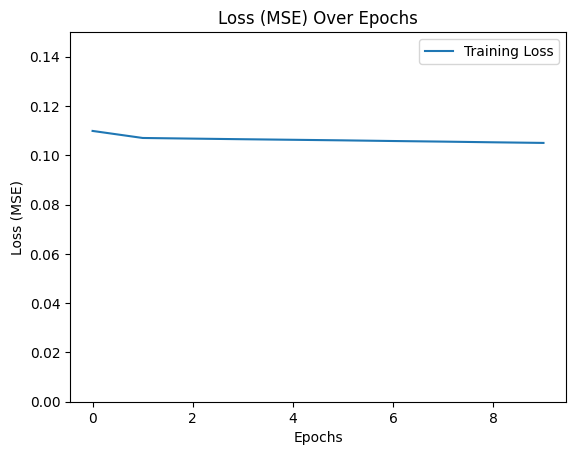

In [15]:
# Extract training and validation losses
train_loss = history.history['loss']
#val_loss = history.history['val_loss']

# Plot both
plt.plot(train_loss, label='Training Loss')
#plt.plot(val_loss, label='Validation Loss', linestyle='--')
plt.ylim(0, 0.15)
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.title('Loss (MSE) Over Epochs')
plt.legend()
plt.show()

In [16]:
# Evaluate the model on the test set
train_loss, train_mae = model.evaluate([Accident_train, Weather_Hr_train], Out_train)

# Print the MAE
print(f"Train MSE: {train_loss}")
print(f"Train MAE: {train_mae}")

1079/1079 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.1042 - mae: 0.1315
Train MSE: 0.10442101210355759
Train MAE: 0.13165736198425293


In [17]:
# Evaluate the model on the test set
test_loss, test_mae = model.evaluate([Accident_test, Weather_Hr_test], Out_test)

# Print the MAE
print(f"Test MSE: {test_loss}")
print(f"Test MAE: {test_mae}")

270/270 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1081 - mae: 0.1334
Test MSE: 0.10776851326227188
Test MAE: 0.1329556107521057


In [18]:
predictions_test = model.predict([Accident_test, Weather_Hr_test])
predictions_train = model.predict([Accident_train, Weather_Hr_train])

270/270 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
1079/1079 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


In [23]:
np.save('11x11/model_data/model_regression_test_predictions_values_10epochs.npy', predictions_test)
np.save('11x11/model_data/model_regression_train_predictions_values_10epochs.npy', predictions_train)

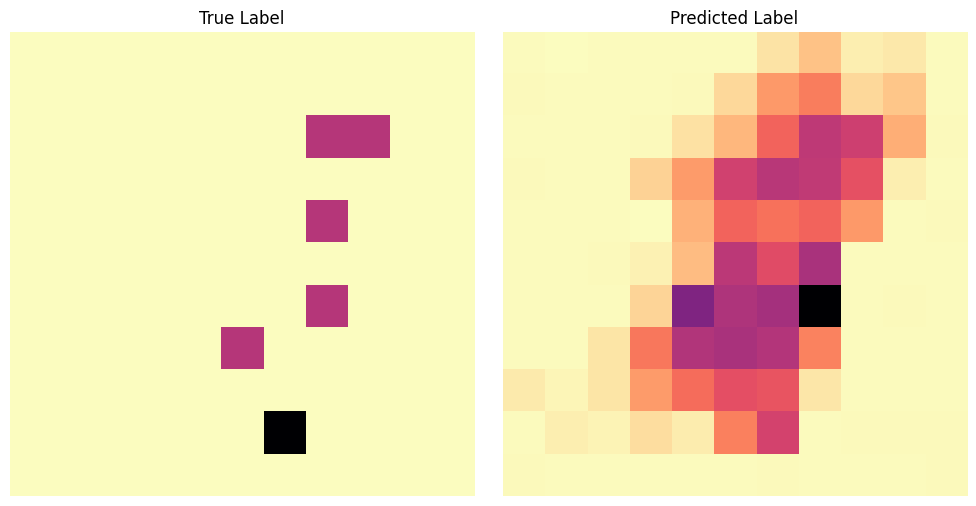

In [20]:
# Plot the true label and predicted label side by side
fig, axes = plt.subplots(1, 2, figsize=(10, 5))  # 1 row, 2 columns

# Plot true label (Y_test[-1])
axes[0].imshow(Out_test[3640], cmap='magma_r')
axes[0].set_title("True Label")
axes[0].axis('off')  # Hide axis for better visualization

# Plot prediction (predictions[-1])
axes[1].imshow(predictions_test[3640], cmap='magma_r')
axes[1].set_title("Predicted Label")
axes[1].axis('off')  # Hide axis for better visualization

# Show the plot
plt.tight_layout()  # Adjust spacing
plt.show()


## 2. Full-Model Classification

In [21]:
#Define inputs
input_past_accidents_shape = layers.Input(shape=(int(img_size), int(img_size), 24)) # Convolution
input_past_traffic_shape = layers.Input(shape=(int(img_size), int(img_size), 1)) # Convolution
input_past_weather_shape = layers.Input(shape=(23, )) #Not binary

#Convolution Layers For Accidents
accidents_layer_1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(input_past_accidents_shape)
accidents_layer_2 = layers.MaxPooling2D(pool_size=(3, 1), strides=(3, 1))(accidents_layer_1)

accidents_layer_3 = layers.Conv2D(30, (3, 3), activation='relu')(accidents_layer_2)
accidents_layer_4 = layers.MaxPooling2D((2, 2))(accidents_layer_3)
accidents_layer_5 = layers.Flatten()(accidents_layer_2)
accidents_layer_6 = layers.Dense(24, activation='relu')(accidents_layer_5)
accidents_layer_7 = layers.Reshape((24, 1))(accidents_layer_6)
accidents_layer_8 = layers.LSTM(24, return_sequences=False)(accidents_layer_7)

#Fully Connected Layers of Weather
weather_layer_1 = layers.Dense(64, activation='relu')(input_past_weather_shape)
weather_layer_2 = layers.Dense(32, activation='relu')(weather_layer_1)
weather_layer_3 = layers.Dense(24, activation='relu')(weather_layer_2)

#Combine Layers
hadamard_product_layer = layers.Multiply()([accidents_layer_8, weather_layer_3])
# Dense layer to produce a vector of length 11*11 (121) - ensure the shape matches
dense_layer_1 = layers.Dense(11 * 11, activation='sigmoid')(hadamard_product_layer)

# Reshape output to (11, 11, 1) for final layer
output_layer = layers.Reshape((11, 11, 1))(dense_layer_1)

model_binary = Model(inputs=[input_past_accidents_shape, input_past_weather_shape], outputs=output_layer)
 
# Model summary
model_binary.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Summarize the model
model_binary.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 11, 11,    │          0 │ -                 │
│ (InputLayer)        │ 24)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 11, 11,    │     13,888 │ input_layer_3[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 3, 11, 64) │          0 │ conv2d_2[0][0]    │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 2112)      │          0 │ max_pooling2d_2[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_5       │ (None, 23)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 24)        │     50,712 │ flatten_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_7 (Dense)     │ (None, 64)        │      1,536 │ input_layer_5[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_2 (Reshape) │ (None, 24, 1)     │          0 │ dense_6[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_8 (Dense)     │ (None, 32)        │      2,080 │ dense_7[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_1 (LSTM)       │ (None, 24)        │      2,496 │ reshape_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_9 (Dense)     │ (None, 24)        │        792 │ dense_8[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_1          │ (None, 24)        │          0 │ lstm_1[0][0],     │
│ (Multiply)          │                   │            │ dense_9[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_10 (Dense)    │ (None, 121)       │      3,025 │ multiply_1[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_3 (Reshape) │ (None, 11, 11, 1) │          0 │ dense_10[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 74,529 (291.13 KB)

 Trainable params: 74,529 (291.13 KB)

 Non-trainable params: 0 (0.00 B)

In [22]:
## Split into training and testing sets with 0.8-0.2
history_binary = model_binary.fit([Accident_train, Weather_Hr_train], Binary_Out_train, epochs=10, batch_size=32)

Epoch 1/10
1079/1079 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.8988 - loss: 0.2631
Epoch 2/10
1079/1079 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.9236 - loss: 0.1742
Epoch 3/10
1079/1079 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.9240 - loss: 0.1734
Epoch 4/10
1079/1079 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.9248 - loss: 0.1724
Epoch 5/10
1079/1079 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.9241 - loss: 0.1731
Epoch 6/10
1079/1079 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.9245 - loss: 0.1726
Epoch 7/10
1079/1079 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.9242 - loss: 0.1728
Epoch 8/10
1079/1079 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.9246 - loss: 0.1723
Epoch 9/10
1079/1079 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.9239 - loss: 0.1731
Epoch 10/10
1079/1079 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.9245 - loss: 0.1722


In [25]:
model_binary.save('11x11/model_data/full_binary_10.keras')

#To load back in, just do:
#loaded_model = load_model('11x11/models_/full_binary.keras')
#loaded_model.predict(x_test)!

In [ ]:
train_loss, train_loss = model_binary.evaluate([Accident_train, Weather_Hr_train], Binary_Out_train)
# Print the results
print(f"Train Loss: {train_loss}")
print(f"Train Accuracy: {train_loss}")

1079/1079 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9260 - loss: 0.1678


In [26]:
# Evaluate the model on the test set
test_loss, test_accuracy = model_binary.evaluate([Accident_test, Weather_Hr_test], Binary_Out_test)

# Print the results
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

270/270 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9234 - loss: 0.1737
Test Loss: 0.17313455045223236
Test Accuracy: 0.9239101409912109


In [27]:
predictions_model_binary_test = model_binary.predict([Accident_test, Weather_Hr_test])
# Threshold at 0.5 to convert output to binary (0 or 1)
binary_predictions_test = (predictions_model_binary_test > 0.5).astype(int)

predictions_model_binary_train = model_binary.predict([Accident_train, Weather_Hr_train])
# Threshold at 0.5 to convert output to binary (0 or 1)
binary_predictions_train= (predictions_model_binary_train > 0.5).astype(int)

270/270 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
1079/1079 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


In [28]:
np.save('11x11/model_data/model_binary_test_predictions_values50.npy', binary_predictions_test)
np.save('11x11/model_data/model_binary_train_predictions_values50.npy', binary_predictions_train)
np.save('11x11/model_data/model_binary_test_predictions_probs50.npy', predictions_model_binary_test)
np.save('11x11/model_data/model_binary_train_predictions_probs50.npy', predictions_model_binary_train)

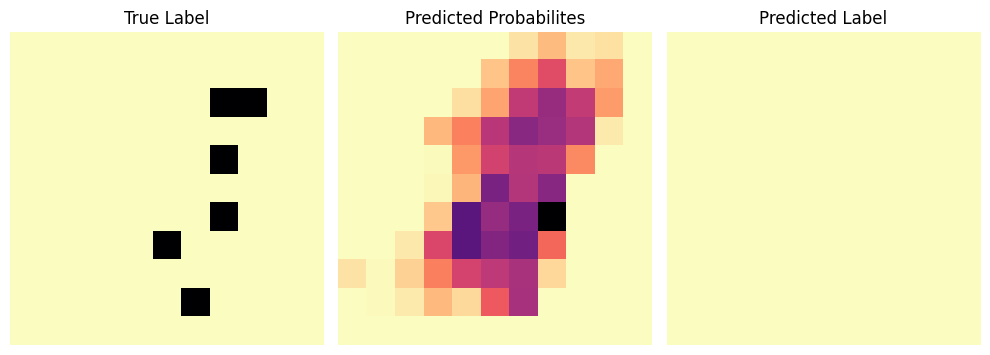

In [29]:
import matplotlib.pyplot as plt

# Plot the true label and predicted label side by side
fig, axes = plt.subplots(1, 3, figsize=(10, 8))  # 1 row, 2 columns
i=3640

# Plot true label (Y_test[-1])
axes[0].imshow(Binary_Out_test[i], cmap='magma_r')
axes[0].set_title("True Label")
axes[0].axis('off')  # Hide axis for better visualization

# Plot prediction (predictions[-1])
axes[1].imshow(predictions_model_binary_test[i], cmap='magma_r')
axes[1].set_title("Predicted Probabilites")
axes[1].axis('off')  # Hide axis for better visualization

# Plot prediction (predictions[-1])
axes[2].imshow(binary_predictions_test[i], cmap='magma_r')
axes[2].set_title("Predicted Label")
axes[2].axis('off')  # Hide axis for better visualization


# Show the plot
plt.tight_layout()  # Adjust spacing
plt.show()


### Plot ROC Curve On Test Data

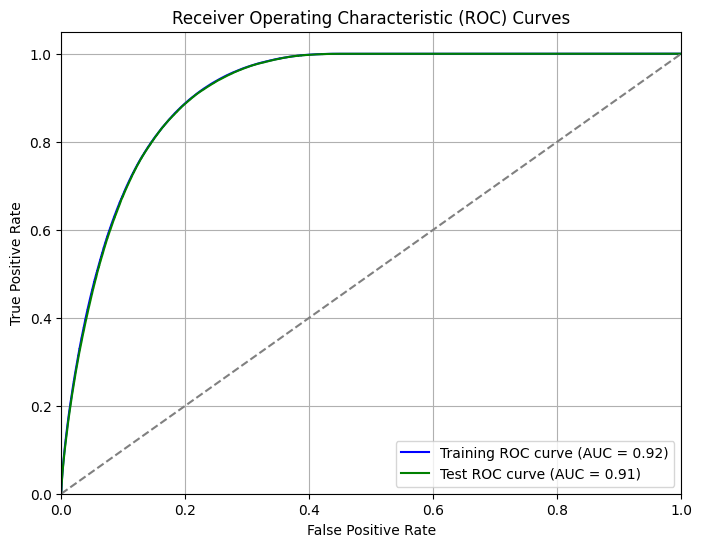

In [30]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Flatten Data for Training Set
Binary_Out_train_flattened = Binary_Out_train.reshape(-1)
binary_predictions_train_flattened = predictions_model_binary_train.reshape(-1)

# Calculate ROC curve for the training set
fpr_train, tpr_train, thresholds_train = roc_curve(Binary_Out_train_flattened, binary_predictions_train_flattened)
roc_auc_train = auc(fpr_train, tpr_train)

# Flatten Data for Testing Set
Binary_Out_test_flattened = Binary_Out_test.reshape(-1)
binary_predictions_test_flattened = predictions_model_binary_test.reshape(-1)

# Calculate ROC curve for the testing set
fpr_test, tpr_test, thresholds_test = roc_curve(Binary_Out_test_flattened, binary_predictions_test_flattened)
roc_auc_test = auc(fpr_test, tpr_test)

# Plot ROC curve for both training and testing sets
plt.figure(figsize=(8, 6))

# Plot training set ROC curve
plt.plot(fpr_train, tpr_train, color='blue', label=f'Training ROC curve (AUC = {roc_auc_train:.2f})')

# Plot testing set ROC curve
plt.plot(fpr_test, tpr_test, color='green', label=f'Test ROC curve (AUC = {roc_auc_test:.2f})')

# Diagonal line representing random model
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Diagonal line (random model)

# Labels and title
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curves')

# Add legend
plt.legend(loc='lower right')

# Show the plot
plt.grid(True)
plt.show()


In [31]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm_test = confusion_matrix(Binary_Out_test_flattened, binary_predictions_test.reshape(-1))#.ravel()
cm_train = confusion_matrix(Binary_Out_train_flattened, binary_predictions_train.reshape(-1))#.ravel()


In [32]:
TN_TEST, FP_TEST, FN_TEST, TP_TEST = cm_test.ravel()
TN_TEST, FP_TEST, FN_TEST, TP_TEST

(956046, 5618, 73810, 8393)

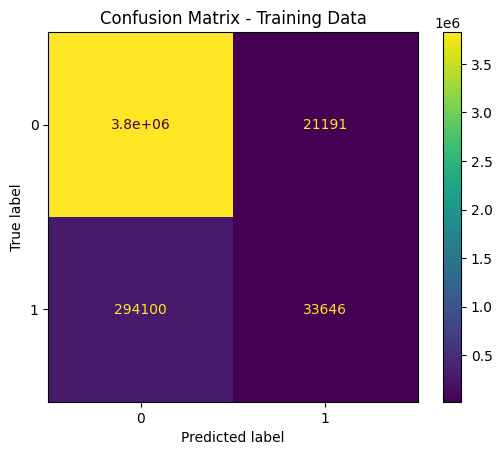

In [33]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm_train,
                              display_labels=[0, 1])
disp.plot()
plt.title("Confusion Matrix - Training Data")
plt.show()

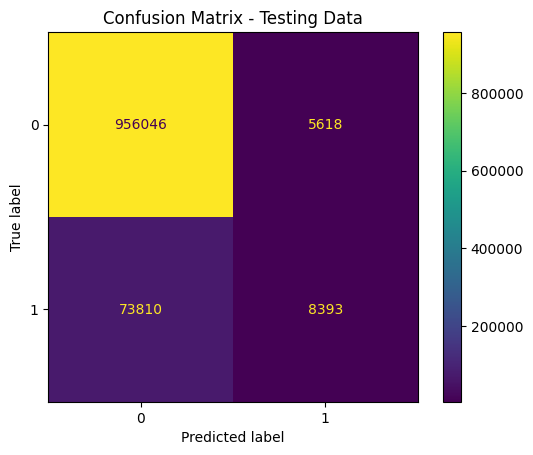

In [34]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm_test,
                              display_labels=[0, 1])
disp.plot()
plt.title("Confusion Matrix - Testing Data")
plt.show()

In [38]:
precision_train = precision_score(Binary_Out_train_flattened, binary_predictions_train.reshape(-1))
recall_train = recall_score(Binary_Out_train_flattened, binary_predictions_train.reshape(-1))
train_accuracy = accuracy_score(Binary_Out_train_flattened, binary_predictions_train.reshape(-1))
precision_train, recall_train, train_accuracy

(0.6135638346371975, 0.10265876623971001, 0.9244809081903068)

In [39]:
precision_test = precision_score(Binary_Out_test_flattened, binary_predictions_test.reshape(-1))
recall_test = recall_score(Binary_Out_test_flattened, binary_predictions_test.reshape(-1))
test_accuracy = accuracy_score(Binary_Out_test_flattened, binary_predictions_test.reshape(-1))
precision_test, recall_test, test_accuracy

(0.5990293340946399, 0.10210089656095277, 0.9239098467525078)

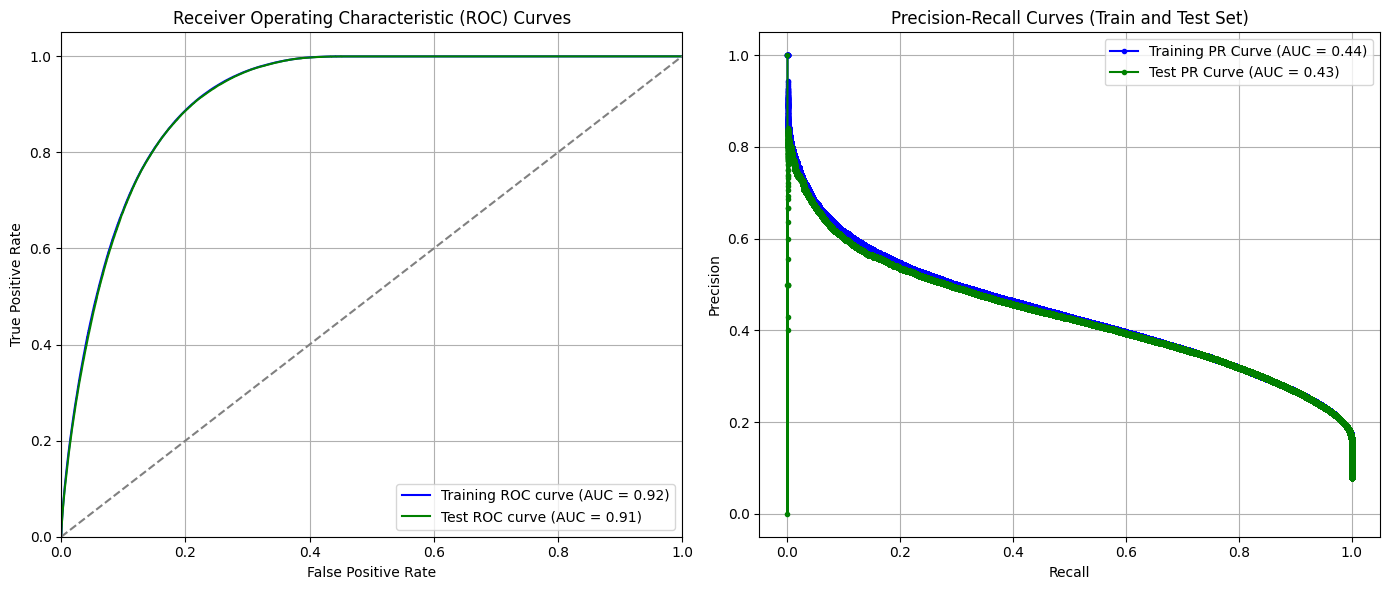

In [40]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, auc
from sklearn.metrics import roc_curve

# Flatten Data for Training Set
Binary_Out_train_flattened = Binary_Out_train.reshape(-1)
binary_predictions_train_flattened = predictions_model_binary_train.reshape(-1)

# Calculate ROC curve for the training set
fpr_train, tpr_train, thresholds_train = roc_curve(Binary_Out_train_flattened, binary_predictions_train_flattened)
roc_auc_train = auc(fpr_train, tpr_train)

# Flatten Data for Testing Set
Binary_Out_test_flattened = Binary_Out_test.reshape(-1)
binary_predictions_test_flattened = predictions_model_binary_test.reshape(-1)

# Calculate ROC curve for the testing set
fpr_test, tpr_test, thresholds_test = roc_curve(Binary_Out_test_flattened, binary_predictions_test_flattened)
roc_auc_test = auc(fpr_test, tpr_test)

# Calculate precision, recall, and thresholds for the training set
precision_train, recall_train, thresholds_train = precision_recall_curve(Binary_Out_train_flattened, binary_predictions_train_flattened)

# Calculate the area under the Precision-Recall curve (PR AUC) for the training set
pr_auc_train = auc(recall_train, precision_train)

# Calculate precision, recall, and thresholds for the test set
precision_test, recall_test, thresholds_test = precision_recall_curve(Binary_Out_test_flattened, binary_predictions_test_flattened)

# Calculate the area under the Precision-Recall curve (PR AUC) for the test set
pr_auc_test = auc(recall_test, precision_test)

# Plot both ROC curve and Precision-Recall curve in one figure with subplots
plt.figure(figsize=(14, 6))

# Subplot 1: ROC curve
plt.subplot(1, 2, 1)  # (rows, columns, index)
plt.plot(fpr_train, tpr_train, color='blue', label=f'Training ROC curve (AUC = {roc_auc_train:.2f})')
plt.plot(fpr_test, tpr_test, color='green', label=f'Test ROC curve (AUC = {roc_auc_test:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Diagonal line (random model)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curves')
plt.legend(loc='lower right')
plt.grid(True)

# Subplot 2: Precision-Recall curve
plt.subplot(1, 2, 2)  # (rows, columns, index)
plt.plot(recall_train, precision_train, marker='.', color='b', label=f'Training PR Curve (AUC = {pr_auc_train:.2f})')
plt.plot(recall_test, precision_test, marker='.', color='g', label=f'Test PR Curve (AUC = {pr_auc_test:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title(f'Precision-Recall Curves (Train and Test Set)')
plt.grid(True)
plt.legend()

# Show the combined plot
plt.tight_layout()
plt.show()


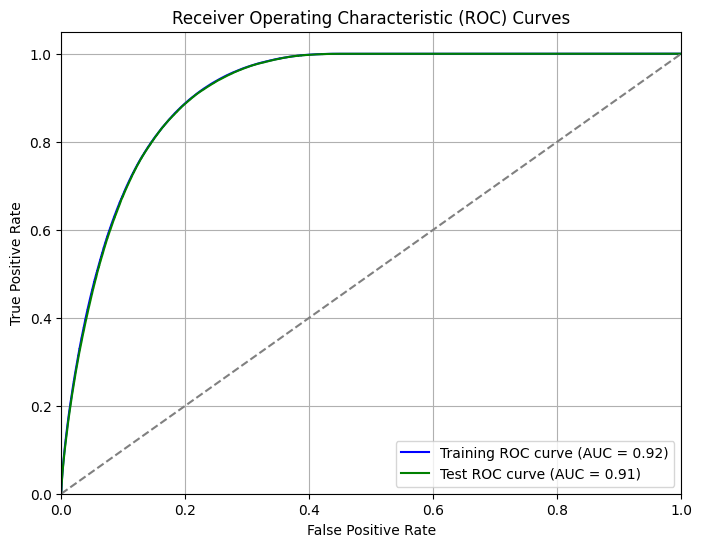

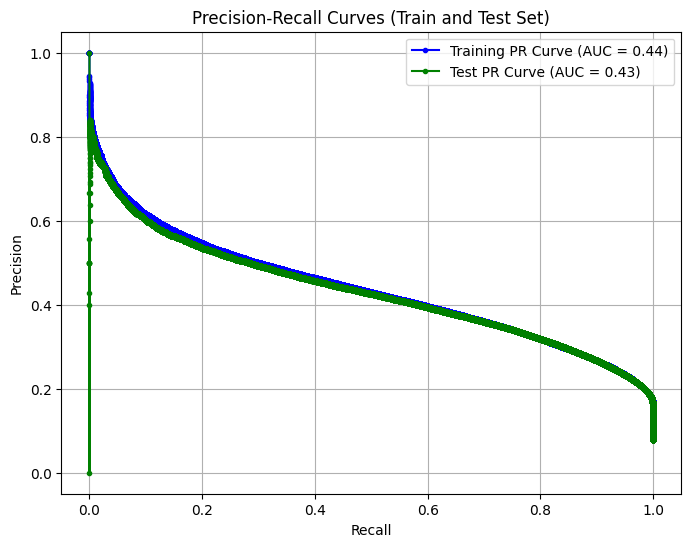

In [41]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, auc
from sklearn.metrics import roc_curve, auc

# Flatten Data for Training Set
Binary_Out_train_flattened = Binary_Out_train.reshape(-1)
binary_predictions_train_flattened = predictions_model_binary_train.reshape(-1)

# Calculate ROC curve for the training set
fpr_train, tpr_train, thresholds_train = roc_curve(Binary_Out_train_flattened, binary_predictions_train_flattened)
roc_auc_train = auc(fpr_train, tpr_train)

# Flatten Data for Testing Set
Binary_Out_test_flattened = Binary_Out_test.reshape(-1)
binary_predictions_test_flattened = predictions_model_binary_test.reshape(-1)

# Calculate ROC curve for the testing set
fpr_test, tpr_test, thresholds_test = roc_curve(Binary_Out_test_flattened, binary_predictions_test_flattened)
roc_auc_test = auc(fpr_test, tpr_test)

# Plot ROC curve for both training and testing sets
plt.figure(figsize=(8, 6))

# Plot training set ROC curve
plt.plot(fpr_train, tpr_train, color='blue', label=f'Training ROC curve (AUC = {roc_auc_train:.2f})')

# Plot testing set ROC curve
plt.plot(fpr_test, tpr_test, color='green', label=f'Test ROC curve (AUC = {roc_auc_test:.2f})')

# Diagonal line representing random model
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Diagonal line (random model)

# Labels and title
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curves')

# Add legend
plt.legend(loc='lower right')

# Show the plot
plt.grid(True)
plt.show()
# Calculate precision, recall, and thresholds for the training set
precision_train, recall_train, thresholds_train = precision_recall_curve(Binary_Out_train_flattened, predictions_model_binary_train.reshape(-1))

# Calculate the area under the Precision-Recall curve (PR AUC) for the training set
pr_auc_train = auc(recall_train, precision_train)

# Calculate precision, recall, and thresholds for the test set
precision_test, recall_test, thresholds_test = precision_recall_curve(Binary_Out_test_flattened, predictions_model_binary_test.reshape(-1))

# Calculate the area under the Precision-Recall curve (PR AUC) for the test set
pr_auc_test = auc(recall_test, precision_test)

# Plot Precision-Recall curve for both training and test sets
plt.figure(figsize=(8, 6))
plt.plot(recall_train, precision_train, marker='.', color='b', label=f'Training PR Curve (AUC = {pr_auc_train:.2f})')
plt.plot(recall_test, precision_test, marker='.', color='g', label=f'Test PR Curve (AUC = {pr_auc_test:.2f})')

# Adding labels and title
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title(f'Precision-Recall Curves (Train and Test Set)')

# Display grid and legend
plt.grid(True)
plt.legend()

# Show the plot
plt.show()


## 3. Regression Model (NoT Spatial)

In [43]:
crashes = pd.read_csv("Traffic_Crashes_-_Crashes_20241203.csv")

In [2]:
gps_epoch = datetime.datetime(1980, 1, 6, 0, 0, 0)

## First, preprocess data into Time-Count Pairs for Regression Model.

In [45]:
crashes_time_midnight= []
for index, row in crashes.iterrows():
    time = row['CRASH_DATE'][-11:]
    #print(time)
    time_obj = datetime.datetime.strptime(time, "%I:%M:%S %p")
    #time_24hr = time_obj.strftime("%H:%M:%S")
    seconds_since_midnight = (time_obj - datetime.datetime.combine(time_obj.date(), datetime.datetime.min.time())).seconds

    crashes_time_midnight.append(seconds_since_midnight)
crashes['Time_from_Midnight'] = crashes_time_midnight

In [46]:
seconds_i=0
time_data_crashes = []
traffic = []
inc = 30
counts = []
while seconds_i < 1440:
    counts_i = len(crashes[(crashes['Time_from_Midnight']>=seconds_i) & (crashes['Time_from_Midnight']<=inc+seconds_i)])
    counts.append(counts_i)
    time_data_crashes.append((2*seconds_i+inc)/2)
    seconds_i+=inc

crash_time_data_transformed = [time_data_crashes[i] for i in range(len(time_data_crashes))]

In [47]:
list1 = crash_time_data_transformed
import random
list2 = counts

# Pair the items from both lists by index
paired_lists = list(zip(list1, list2))

# Calculate the number of pairs to sample (80% of the total number of pairs)
sample_size = int(len(paired_lists) * 0.8)

# Randomly sample 80% of the paired items
sampled_pairs = random.sample(paired_lists, sample_size)
non_sampled_pairs = [pair for pair in paired_lists if pair not in sampled_pairs]

# Unzip the sampled pairs back into two lists (if needed)
sampled_list1, sampled_list2 = zip(*sampled_pairs)
non_sampled_list1, non_sampled_list2 = zip(*non_sampled_pairs) if non_sampled_pairs else ([], [])

# Save the results
train_X, train_y  = sampled_list1, sampled_list2
test_X, test_y = non_sampled_list1, non_sampled_list2

/var/folders/6d/ffdjbx496k5dqjgrkzxf2zlw0000gp/T/ipykernel_57078/1650647132.py:26: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([min_val, max_val], [min_val, max_val], 'k--', label='y = x', color='black')  # Dashed line


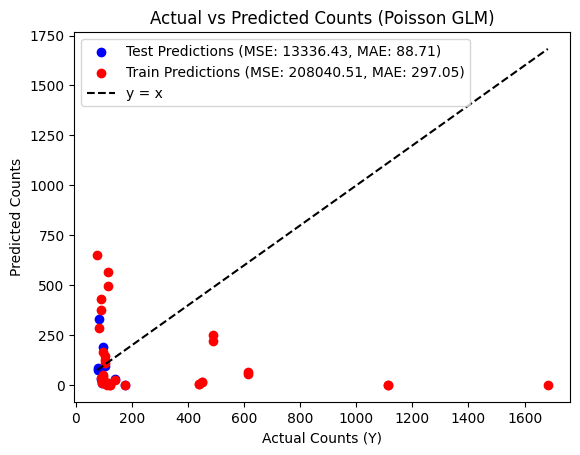

In [48]:

# Fit the Poisson GLM model
poisson_model = sm.GLM(train_y, train_X, family=Poisson()).fit()

# Make predictions using the fitted model
test_predictions = poisson_model.predict(test_X)
train_predictions = poisson_model.predict(train_X)

# Calculate MSE and MAE for the test data
mse_test = mean_squared_error(test_y, test_predictions)
mae_test = mean_absolute_error(test_y, test_predictions)

# Calculate MSE and MAE for the train data
mse_train = mean_squared_error(train_y, train_predictions)
mae_train = mean_absolute_error(train_y, train_predictions)

# Create legend labels with MSE and MAE values
test_label = f'Test Predictions (MSE: {mse_test:.2f}, MAE: {mae_test:.2f})'
train_label = f'Train Predictions (MSE: {mse_train:.2f}, MAE: {mae_train:.2f})'

# Visualizing the actual vs predicted counts
plt.scatter(test_y, test_predictions, label=test_label, color='blue')
plt.scatter(train_y, train_predictions, label=train_label, color='red')
# Add the y = x line (diagonal line)
min_val = min(min(test_y), min(train_y))  # Min value to set the axis limits
max_val = max(max(test_y), max(train_y))  # Max value to set the axis limits
plt.plot([min_val, max_val], [min_val, max_val], 'k--', label='y = x', color='black')  # Dashed line

# Adding labels and title
plt.xlabel("Actual Counts (Y)")
plt.ylabel("Predicted Counts")
plt.title("Actual vs Predicted Counts (Poisson GLM)")

# Adding a legend
plt.legend()

# Show the plot
plt.show()